This notebook detects 2 class objects.
- class1: helmet without impact
- class2: helmet with impact

Object Detection part is based on [EfficientDet notebook](https://www.kaggle.com/shonenkov/training-efficientdet) for [global wheat detection competition](https://www.kaggle.com/c/global-wheat-detection) by [shonenkov](https://www.kaggle.com/shonenkov), which is using [github repos efficientdet-pytorch](https://github.com/rwightman/efficientdet-pytorch) by [@rwightman](https://www.kaggle.com/rwightman).

Training part can be foud [here](https://www.kaggle.com/its7171/2class-object-detection-training/).

In [1]:
!pip install ../input/nfl-lib/timm-0.1.26-py3-none-any.whl
!tar xfz ../input/nfl-lib/pkgs.tgz
# for pytorch1.6
cmd = "sed -i -e 's/ \/ / \/\/ /' timm-efficientdet-pytorch/effdet/bench.py"
!$cmd

Processing /kaggle/input/nfl-lib/timm-0.1.26-py3-none-any.whl


In [2]:
import sys
sys.path.insert(0, "timm-efficientdet-pytorch")
sys.path.insert(0, "omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pandas as pd
import gc
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet
import warnings

warnings.filterwarnings("ignore")

DATA_ROOT_PATH = 'test_images'
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)

In [3]:
def mk_images(video_name, video_labels, video_dir, out_dir, only_with_impact=True):
    video_path=f"{video_dir}/{video_name}"
    video_name = os.path.basename(video_path)
    vidcap = cv2.VideoCapture(video_path)
    if only_with_impact:
        boxes_all = video_labels.query("video == @video_name")
        print(video_path, boxes_all[boxes_all.impact == 1.0].shape[0])
    else:
        print(video_path)
    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        frame += 1
        if only_with_impact:
            boxes = video_labels.query("video == @video_name and frame == @frame")
            boxes_with_impact = boxes[boxes.impact == 1.0]
            if boxes_with_impact.shape[0] == 0:
                continue
        img_name = f"{video_name}_frame{frame}"
        image_path = f'{out_dir}/{video_name}'.replace('.mp4',f'_{frame}.png')
        _ = cv2.imwrite(image_path, img)

In [4]:
out_dir = DATA_ROOT_PATH
if not os.path.exists(out_dir):
    !mkdir -p $out_dir
    video_dir = '/kaggle/input/nfl-impact-detection/test'
    uniq_video = [path.split('/')[-1] for path in glob(f'{video_dir}/*.mp4')]
    for video_name in uniq_video:
        mk_images(video_name, pd.DataFrame(), video_dir, out_dir, only_with_impact=False)

/kaggle/input/nfl-impact-detection/test/57906_000718_Sideline.mp4
/kaggle/input/nfl-impact-detection/test/57906_000718_Endzone.mp4
/kaggle/input/nfl-impact-detection/test/57995_000109_Endzone.mp4
/kaggle/input/nfl-impact-detection/test/58102_002798_Sideline.mp4
/kaggle/input/nfl-impact-detection/test/57995_000109_Sideline.mp4
/kaggle/input/nfl-impact-detection/test/58102_002798_Endzone.mp4


In [5]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [6]:
class DatasetRetriever(Dataset):
    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}', cv2.IMREAD_COLOR).copy().astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [7]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d6')
    net = EfficientDet(config, pretrained_backbone=False)
    config.num_classes = 2
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

# net = load_net('../input/nfl-models//best-checkpoint-002epoch.bin')
# net = load_net('../input/nfl-models-efdnet/best-checkpoint-008epoch.bin') ##621d912ef2be43a044efbfbfc3cd0050c52aab4d aug1
# net = load_net('../input/nfl-models-efdnet/best-checkpoint-016epoch.bin') ##b0ed5b14e56b7d3caa392e1456e5c8978a2fc9e4 more aug2
net = load_net('../input/nfl-models-efdnet/best-checkpoint-019epoch.bin') ##514ba8ed27f1c8fbe7563dde8041a4ca5ee75ebd mixup+cutmix aug3

In [8]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1] for path in glob(f'{DATA_ROOT_PATH}/*.png')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [9]:
def make_predictions(images, score_threshold=0.5):
    images = torch.stack(images).cuda().float()
    box_list = []
    score_list = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]   
            label = det[i].detach().cpu().numpy()[:,5]
            # useing only label = 2
            indexes = np.where((scores > score_threshold) & (label == 2))[0]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            box_list.append(boxes[indexes])
            score_list.append(scores[indexes])
    return box_list, score_list
import matplotlib.pyplot as plt

In [10]:
SCORE_TH = 0.56

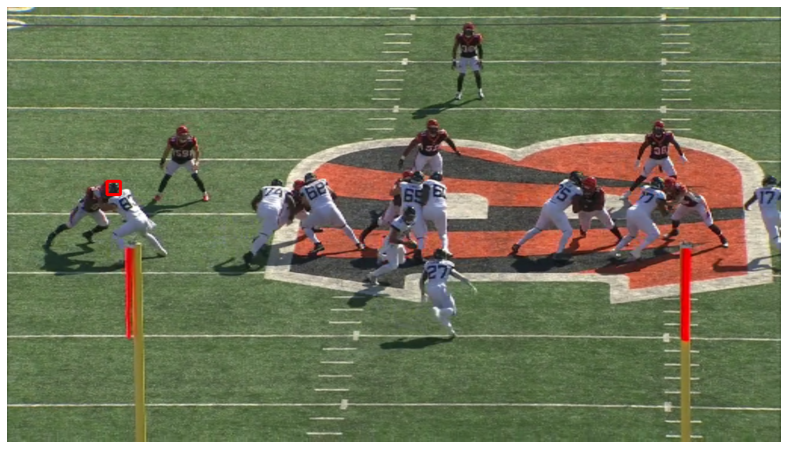

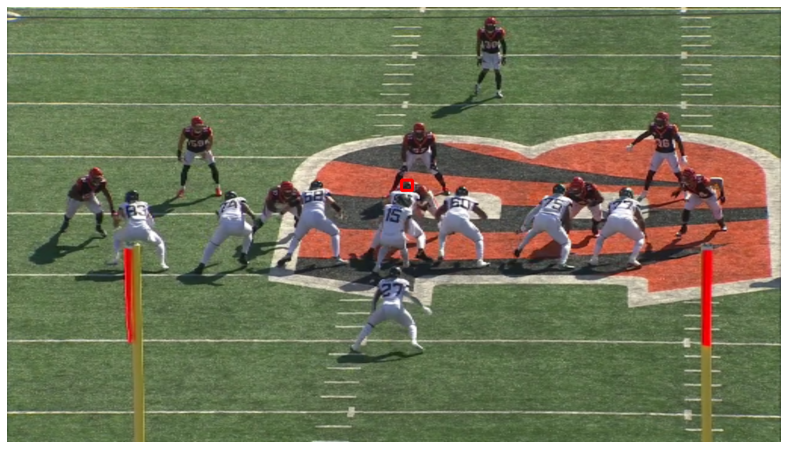

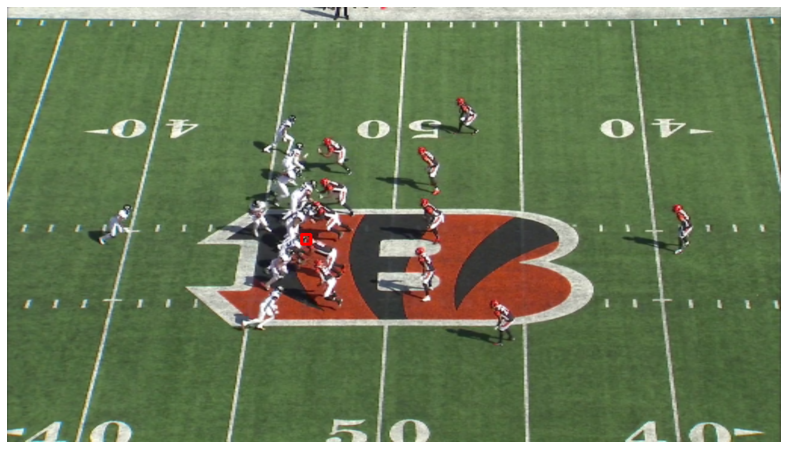

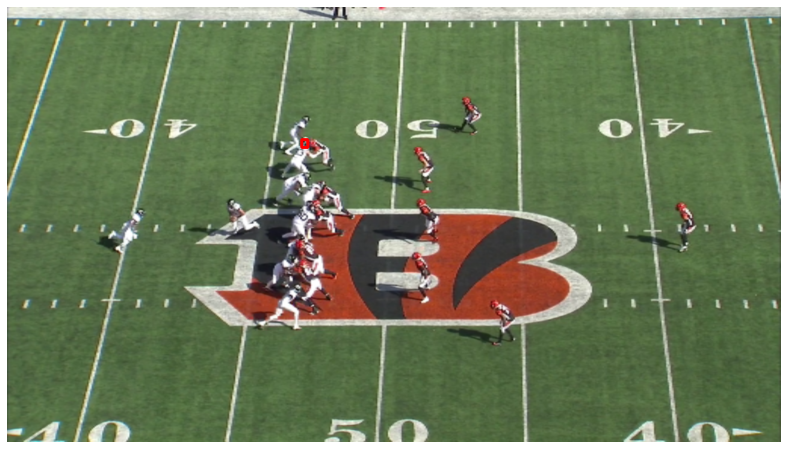

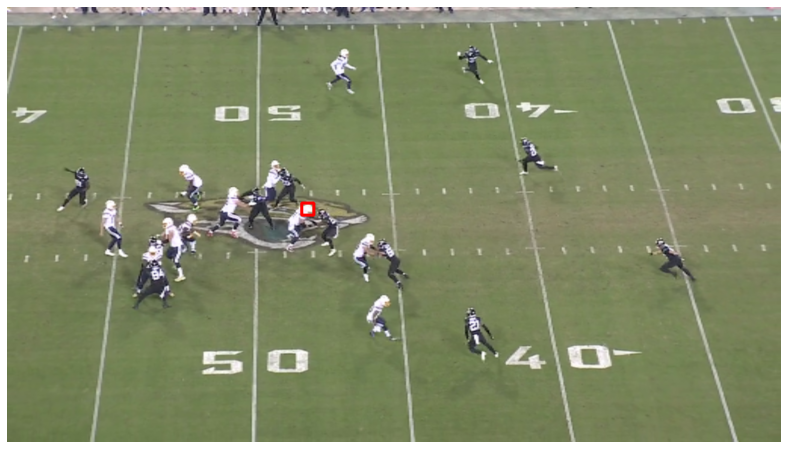

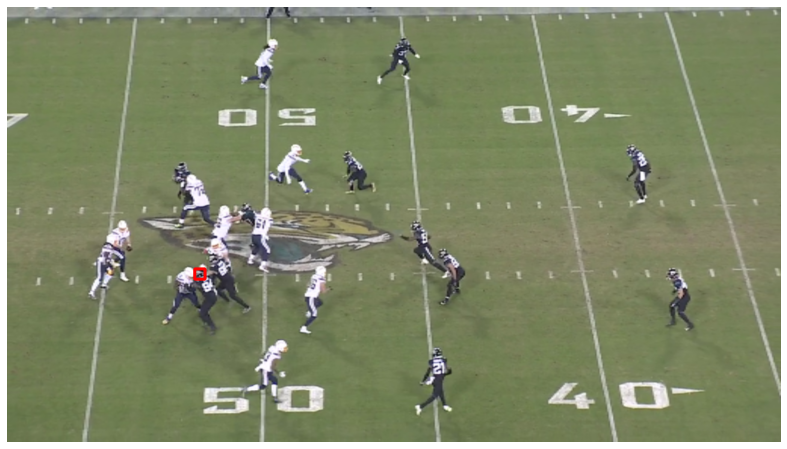

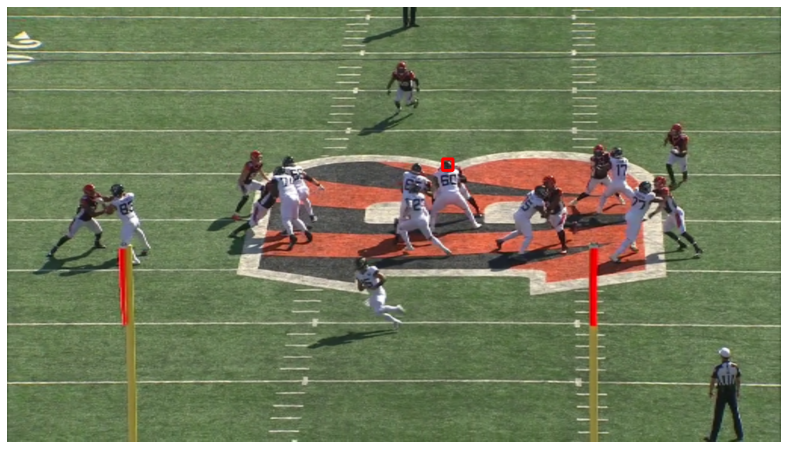

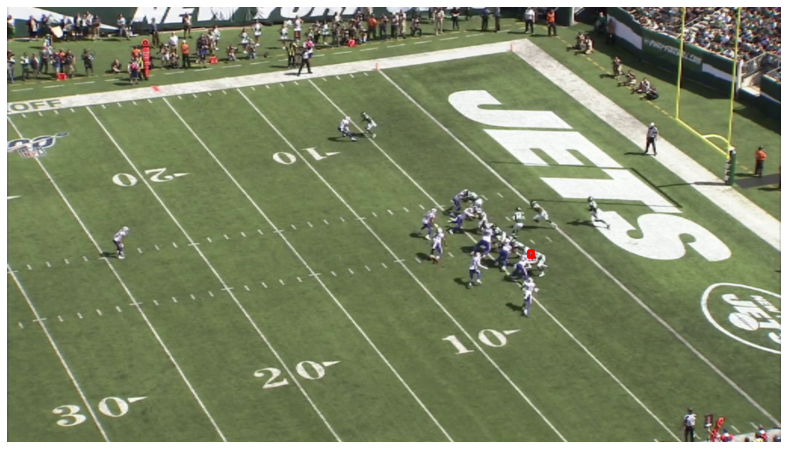

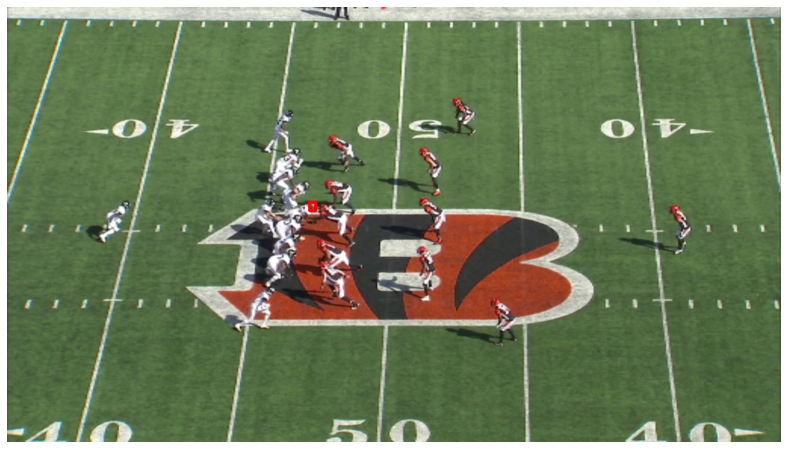

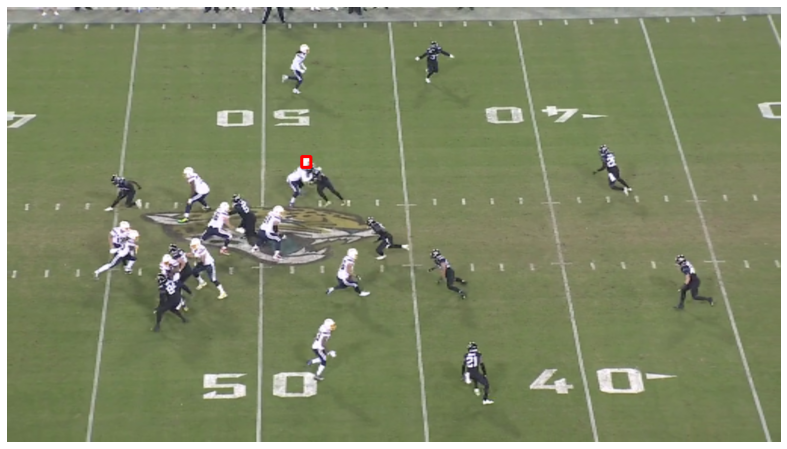

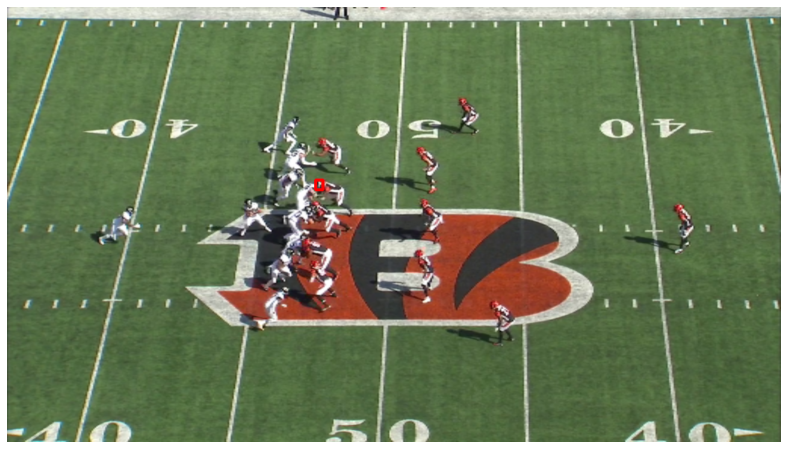

In [11]:
#check prediction

cnt = 0
for images, image_ids in data_loader:
    box_list, score_list = make_predictions(images, score_threshold=SCORE_TH)
    for i in range(len(images)):
        sample = images[i].permute(1,2,0).cpu().numpy()
        boxes = box_list[i].astype(np.int32).clip(min=0, max=511)
        scores = score_list[i]
        if len(scores) >= 1:
            fig, ax = plt.subplots(1, 1, figsize=(16, 8))
            sample = cv2.resize(sample , (int(1280), int(720)))
            for box,score in zip(boxes,scores):
                box[0] = box[0] * 1280 / 512
                box[1] = box[1] * 720 / 512
                box[2] = box[2] * 1280 / 512
                box[3] = box[3] * 720 / 512
                cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 3)
            ax.set_axis_off()
            ax.imshow(sample);
            cnt += 1
    if cnt >= 10:
        break

In [12]:
result_image_ids = []
results_boxes = []
results_scores = []
for images, image_ids in data_loader:
    box_list, score_list = make_predictions(images, score_threshold=SCORE_TH)
    for i, image in enumerate(images):
        boxes = box_list[i]
        scores = score_list[i]
        image_id = image_ids[i]
        boxes[:, 0] = (boxes[:, 0] * 1280 / 512)
        boxes[:, 1] = (boxes[:, 1] * 720 / 512)
        boxes[:, 2] = (boxes[:, 2] * 1280 / 512)
        boxes[:, 3] = (boxes[:, 3] * 720 / 512)
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        boxes = boxes.astype(np.int32)
        boxes[:, 0] = boxes[:, 0].clip(min=0, max=1280-1)
        boxes[:, 2] = boxes[:, 2].clip(min=0, max=1280-1)
        boxes[:, 1] = boxes[:, 1].clip(min=0, max=720-1)
        boxes[:, 3] = boxes[:, 3].clip(min=0, max=720-1)
        result_image_ids += [image_id]*len(boxes)
        results_boxes.append(boxes)
        results_scores.append(scores)

In [13]:
box_df = pd.DataFrame(np.concatenate(results_boxes), columns=['left', 'top', 'width', 'height'])
test_df = pd.DataFrame({'scores':np.concatenate(results_scores), 'image_name':result_image_ids})
test_df = pd.concat([test_df, box_df], axis=1)

test_df = test_df[test_df.scores > SCORE_TH]
test_df.shape

(103, 6)

In [14]:
#gameKey,playID,view,video,frame,left,width,top,height
#57590,3607,Endzone,57590_003607_Endzone.mp4,1,1,1,1,1
test_df['gameKey'] = test_df.image_name.str.split('_').str[0].astype(int)
test_df['playID'] = test_df.image_name.str.split('_').str[1].astype(int)
test_df['view'] = test_df.image_name.str.split('_').str[2]
test_df['frame'] = test_df.image_name.str.split('_').str[3].str.replace('.png','').astype(int)
test_df['video'] = test_df.image_name.str.rsplit('_',1).str[0] + '.mp4'
test_df = test_df[["gameKey","playID","view","video","frame","left","width","top","height"]]
test_df

gameKey  playID      view                      video  frame  left  width  \
0      57995     109   Endzone   57995_000109_Endzone.mp4     57   166     22   
1      57995     109   Endzone   57995_000109_Endzone.mp4     32   653     18   
2      57995     109  Sideline  57995_000109_Sideline.mp4     39   489     14   
3      57995     109  Sideline  57995_000109_Sideline.mp4     54   488     11   
4      58102    2798  Sideline  58102_002798_Sideline.mp4    130   489     18   
..       ...     ...       ...                        ...    ...   ...    ...   
98     57995     109  Sideline  57995_000109_Sideline.mp4     48   514     10   
99     58102    2798  Sideline  58102_002798_Sideline.mp4    156   296     13   
100    57995     109   Endzone   57995_000109_Endzone.mp4     46   469     21   
101    58102    2798  Sideline  58102_002798_Sideline.mp4    134   595     16   
102    58102    2798  Sideline  58102_002798_Sideline.mp4    134   509     14   

     top  height  
0    289      22  
1    287      17  
2    377      15  
3    220      11  
4    325      20  
..   ...     ...  
98   290      14  
99   378      14  
100  282      30  
101  370      20  
102  331      15  

[103 rows x 9 columns]

In [15]:
# clearing working dir
# be careful when running this code on local environment!
# !rm -rf *
!mv * /tmp/

In [16]:
import nflimpact
env = nflimpact.make_env()
env.predict(test_df) # df is a pandas dataframe of your entire submission file